In [1]:
import torch
from torch import nn,optim
from torch.utils.data import Dataset,TensorDataset,DataLoader
import tqdm

import numpy as np

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image
import time

### imageの準備

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar xf 102flowers.tgz
!mkdir oxford-102
!mkdir oxford-102/jpg
!mv jpg/*.jpg oxford-102/jpg

In [2]:
img_data=ImageFolder("./oxford-102/",
                     transform=transforms.Compose([transforms.Resize(80),transforms.CenterCrop(64),transforms.ToTensor()]))
batch_size=64
img_loader=DataLoader(img_data,batch_size=batch_size,shuffle=True)

### GnetとDnetの定義

In [3]:
nz=100
ngf=32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main=nn.Sequential(
            nn.ConvTranspose2d(nz,ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf*2,ngf*1,4,2,1,bias=False),
            nn.BatchNorm2d(ngf*1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf*1,3,4,2,1,bias=True),
            nn.Tanh()
            )

    def forward(self,x):
        out=self.main(x)
        return out

In [4]:
ndf=32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main=nn.Sequential(
            nn.Conv2d(3,ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf*8,1,4,1,0,bias=True)
            )

    def forward(self,x):
        out=self.main(x)
        return out.squeeze()

In [5]:
d=DNet().to("cuda:0")
g=GNet().to("cuda:0")

opt_d=optim.Adam(d.parameters(),lr=0.0002,betas=(0.5,0.999))
opt_g=optim.Adam(g.parameters(),lr=0.0002,betas=(0.5,0.999))

ones=torch.ones(batch_size).to("cuda:0")
zeros=torch.zeros(batch_size).to("cuda:0")

loss_f=nn.BCEWithLogitsLoss()

fixed_z = torch.randn(batch_size,nz,1,1).to("cuda:0")
gif_z = torch.randn(1,nz,1,1).to("cuda:0")

### 訓練関数の定義

In [6]:
from statistics import mean

def train_dcgan(g,d,opt_g,opt_d,loader):
    log_loss_g=[]
    log_loss_d=[]
    for real_img,_ in tqdm.tqdm(loader):
        batch_len=len(real_img)
        real_img=real_img.to("cuda:0")
        z=torch.randn(batch_len,nz,1,1).to("cuda:0")
        #fake_img=g.forward(z)
        fake_img=g(z)
        fake_img_tensor=fake_img.detach()
        out=d.forward(fake_img)
        loss_g=loss_f(out,ones[:batch_len])
        log_loss_g.append(loss_g.item())
        d.zero_grad(),g.zero_grad()
        loss_g.backward()
        opt_g.step()
        real_out=d.forward(real_img)
        loss_d_real=loss_f(real_out,ones[:batch_len])

        fake_img=fake_img_tensor
        fake_out=d.forward(fake_img_tensor)
        loss_d_fake=loss_f(fake_out,zeros[:batch_len])

        loss_d=loss_d_real+loss_d_fake
        log_loss_d.append(loss_d.item())
        d.zero_grad(),g.zero_grad()
        loss_d.backward()
        opt_d.step()

    return mean(log_loss_g),mean(log_loss_d)

### 訓練開始

In [7]:
import os
if not os.path.exists("data"):
    os.mkdir("data")

In [8]:
total_time=0.0
average_time=0.0
iter_epoch=20

gif_data = []

for epoch in range(iter_epoch):
    t_start=time.time()
    print(epoch)
    train_dcgan(g,d,opt_g,opt_d,img_loader)
    t_finish=time.time()
    total_time+=t_finish-t_start
    average_time=total_time/(epoch+1)
    print("runtime = ",t_finish-t_start,"sec")
    print("expected remaining time = ",average_time*(iter_epoch-(epoch+1)),"sec",":",average_time*(iter_epoch-(epoch+1))/60,"minute")
    gif_data.append(g(gif_z))
    if epoch%10==0:
        torch.save(g.state_dict(),"./data/g_{:03d}.prm".format(epoch),pickle_protocol=4)
        torch.save(d.state_dict(),"./data/d_{:03d}.prm".format(epoch),pickle_protocol=4)
        generated_img=g(fixed_z)
        save_image(generated_img,"./data/{:03d}.jpg".format(epoch))

  0%|          | 0/128 [00:00<?, ?it/s]

0


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.24352288246155 sec
expected remaining time =  707.6269347667694 sec : 11.793782246112823 minute
1


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.55651092529297 sec
expected remaining time =  673.2003042697906 sec : 11.220005071163177 minute
2


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  36.93696999549866 sec
expected remaining time =  633.1763548851013 sec : 10.552939248085021 minute
3


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.97810935974121 sec
expected remaining time =  598.8604526519775 sec : 9.981007544199626 minute
4


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  36.45678663253784 sec
expected remaining time =  558.5156993865967 sec : 9.308594989776612 minute
5


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  36.74644184112549 sec
expected remaining time =  520.1427971522014 sec : 8.669046619203357 minute
6


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.4828155040741 sec
expected remaining time =  483.60214897564475 sec : 8.060035816260745 minute
7


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.269736528396606 sec
expected remaining time =  446.5063405036926 sec : 7.4417723417282104 minute
8


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.65589785575867 sec
expected remaining time =  409.8438563081953 sec : 6.830730938469922 minute
9


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  38.4677050113678 sec
expected remaining time =  373.7944965362549 sec : 6.229908275604248 minute
10


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.70982599258423 sec
expected remaining time =  336.6853547963229 sec : 5.611422579938715 minute
11


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.97668123245239 sec
expected remaining time =  299.65400250752765 sec : 4.994233375125461 minute
12


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  38.73290538787842 sec
expected remaining time =  262.8844126187838 sec : 4.38140687697973 minute
13


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.71685838699341 sec
expected remaining time =  225.39890037264144 sec : 3.7566483395440238 minute
14


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  38.17392015457153 sec
expected remaining time =  188.03489589691162 sec : 3.1339149316151937 minute
15


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  36.88469624519348 sec
expected remaining time =  150.2473459839821 sec : 2.5041224330663683 minute
16


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  38.2865355014801 sec
expected remaining time =  112.81339754777795 sec : 1.8802232924629658 minute
17


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.87758946418762 sec
expected remaining time =  75.23927876684401 sec : 1.2539879794474003 minute
18


  0%|          | 0/128 [00:00<?, ?it/s]

runtime =  37.200682163238525 sec
expected remaining time =  37.597589003412345 sec : 0.6266264833902058 minute
19


100%|██████████| 128/128 [00:36<00:00,  3.49it/s]

runtime =  36.698503255844116 sec
expected remaining time =  0.0 sec : 0.0 minute


In [ ]:
for image in frames[i]:
                             ims[i].append([plt.imshow(np.asnumpy(image), animated=True)])
                            ani = animation.ArtistAnimation(fig, ims[i], interval=50, blit=True,repeat_delay=1000)
                            ani.save("./result/"+f'{i}_{elapsed_episode[i]:03}.gif', writer="imagemagick")

MovieWriter imagemagick unavailable; using Pillow instead.


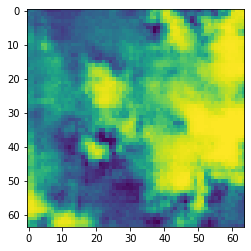

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

ims = []
fig = plt.figure()

for image in gif_data:
    ims.append([plt.imshow(image[0][0].to('cpu').detach().numpy().copy(), animated=True)])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=1000)
ani.save("./"+f'generation_process.gif', writer="imagemagick")